In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

#sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import mean_squared_error

#keras
from keras import layers, Input, Model
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, BatchNormalization, Flatten
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers.experimental.preprocessing import Normalization


#others
import os
import json
from pathlib import Path
import joblib
import folium
import geojson
import geopandas as gpd
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBRegressor, plot_importance, plot_tree

In [2]:
data = yf.download('NVDA AMD INTC', start='2014-01-01', end='2021-08-04', group_by='ticker')

[*********************100%***********************]  3 of 3 completed


In [3]:
data

INTC                                                        \
                 Open       High        Low      Close  Adj Close    Volume   
Date                                                                          
2014-01-02  25.780001  25.820000  25.469999  25.790001  20.678694  31833300   
2014-01-03  25.860001  25.900000  25.600000  25.780001  20.670673  27796700   
2014-01-06  25.770000  25.790001  25.450001  25.459999  20.414097  28682300   
2014-01-07  25.540001  25.730000  25.469999  25.590000  20.518332  19665100   
2014-01-08  25.639999  25.709999  25.299999  25.430000  20.390043  29680500   
...               ...        ...        ...        ...        ...       ...   
2021-07-28  53.029999  53.919998  52.939999  53.070000  52.363216  28478800   
2021-07-29  53.480000  54.099998  53.320000  53.700001  52.984825  16886600   
2021-07-30  53.650002  53.900002  53.250000  53.720001  53.004562  16460000   
2021-08-02  53.990002  54.470001  53.540001  53.680000  52.965092  18098100   
2021-08-03  53.889999  54.160000  53.259998  54.060001  53.340031  16375900   

                   AMD                                                  \
                  Open        High         Low       Close   Adj Close   
Date                                                                     
2014-01-02    3.850000    3.980000    3.840000    3.950000    3.950000   
2014-01-03    3.980000    4.000000    3.880000    4.000000    4.000000   
2014-01-06    4.010000    4.180000    3.990000    4.130000    4.130000   
2014-01-07    4.190000    4.250000    4.110000    4.180000    4.180000   
2014-01-08    4.230000    4.260000    4.140000    4.180000    4.180000   
...                ...         ...         ...         ...         ...   
2021-07-28   93.440002   98.709999   89.650002   97.930000   97.930000   
2021-07-29   96.580002  105.739998   96.580002  102.949997  102.949997   
2021-07-30  101.599998  106.970001  101.379997  106.190002  106.190002   
2021-08-02  105.930000  110.330002  103.830002  108.629997  108.629997   
2021-08-03  108.150002  114.849998  107.660004  112.559998  112.559998   

                             NVDA                                      \
               Volume        Open        High         Low       Close   
Date                                                                    
2014-01-02   20548400    3.980000    3.995000    3.930000    3.965000   
2014-01-03   22887200    3.972500    3.980000    3.905000    3.917500   
2014-01-06   42398300    3.957500    4.000000    3.920000    3.970000   
2014-01-07   42932100    4.010000    4.050000    3.982500    4.035000   
2014-01-08   30678700    4.050000    4.110000    4.035000    4.090000   
...               ...         ...         ...         ...         ...   
2021-07-28  140561000  193.190002  196.460007  189.949997  195.029999   
2021-07-29  164091800  195.190002  198.529999  193.279999  196.619995   
2021-07-30  125567000  194.179993  196.300003  192.630005  194.990005   
2021-08-02  115581900  197.000000  199.610001  193.610001  197.500000   
2021-08-03  157723100  197.399994  202.220001  192.199997  198.149994   

                                  
             Adj Close    Volume  
Date                              
2014-01-02    3.745882  26009200  
2014-01-03    3.701007  25933200  
2014-01-06    3.750607  40949200  
2014-01-07    3.812014  33328800  
2014-01-08    3.863974  30819200  
...                ...       ...  
2021-07-28  194.971725  20219100  
2021-07-29  196.561264  19078100  
2021-07-30  194.931763  18322900  
2021-08-02  197.441010  21744400  
2021-08-03  198.090790  30181100  

[1910 rows x 18 columns]

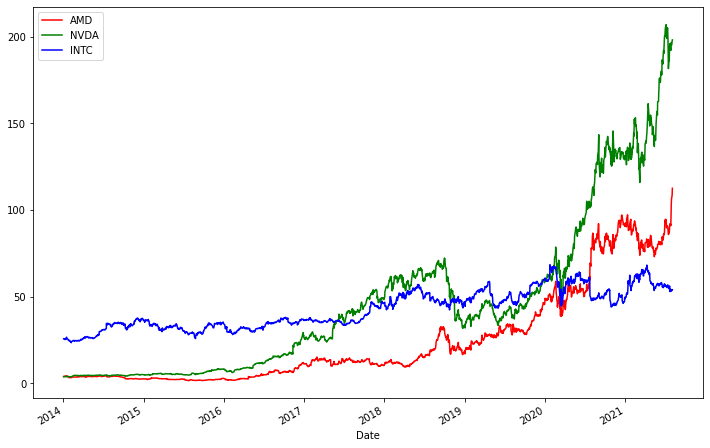

In [4]:
data['AMD']['Close'].plot(figsize=(12,8), color='red', label='AMD')
data['NVDA']['Close'].plot(color='green', label='NVDA')
data['INTC']['Close'].plot(color='blue', label='INTC')
plt.legend()

In [5]:
tickers_list = ['NVDA', 'AMD', 'INTC']
tickers_data = {}

for ticker in tickers_list:
    ticker_object = yf.Ticker(ticker)

    temp = pd.DataFrame.from_dict(ticker_object.info, orient='index')
    temp.reset_index(inplace=True)
    temp.columns = ['Attribute', 'Recent']

    tickers_data[ticker] = temp

tickers_data

{'NVDA':                Attribute                                             Recent
 0                    zip                                              95051
 1                 sector                                         Technology
 2      fullTimeEmployees                                              18975
 3    longBusinessSummary  NVIDIA Corporation operates as a visual comput...
 4                   city                                        Santa Clara
 ..                   ...                                                ...
 146        dividendYield                                             0.0005
 147              bidSize                                                800
 148              dayHigh                                             300.59
 149   regularMarketPrice                                              296.4
 150             logo_url               https://logo.clearbit.com/nvidia.com
 
 [151 rows x 2 columns],
 'AMD':                Attribute         

In [6]:
#full list of infos

#'zip', 'sector', 'fullTimeEmployees', 'longBusinessSummary', 'city', 'phone', 'state', 'country', 'companyOfficers', 'website', 'maxAge',
# 'address1', 'industry', 'previousClose', 'regularMarketOpen', 'twoHundredDayAverage', 'trailingAnnualDividendYield', 'payoutRatio', 'volume24Hr',
#  'regularMarketDayHigh', 'navPrice', 'averageDailyVolume10Day', 'totalAssets', 'regularMarketPreviousClose', 'fiftyDayAverage', 'trailingAnnualDividendRate',
#  'open', 'toCurrency', 'averageVolume10days', 'expireDate', 'yield', 'algorithm', 'dividendRate', 'exDividendDate', 'beta', 'circulatingSupply', 'startDate',
#  'regularMarketDayLow', 'priceHint', 'currency', 'trailingPE', 'regularMarketVolume', 'lastMarket', 'maxSupply', 'openInterest', 'marketCap', 'volumeAllCurrencies',
#  'strikePrice', 'averageVolume', 'priceToSalesTrailing12Months', 'dayLow', 'ask', 'ytdReturn', 'askSize', 'volume', 'fiftyTwoWeekHigh', 'forwardPE', 'fromCurrency',
#  'fiveYearAvgDividendYield', 'fiftyTwoWeekLow', 'bid', 'tradeable', 'dividendYield', 'bidSize', 'dayHigh', 'exchange', 'shortName', 'longName', 'exchangeTimezoneName',
#  'exchangeTimezoneShortName', 'isEsgPopulated', 'gmtOffSetMilliseconds', 'quoteType', 'symbol', 'messageBoardId', 'market', 'annualHoldingsTurnover', 'enterpriseToRevenue',
#  'beta3Year', 'profitMargins', 'enterpriseToEbitda', '52WeekChange', 'morningStarRiskRating', 'forwardEps', 'revenueQuarterlyGrowth', 'sharesOutstanding', 'fundInceptionDate',
#  'annualReportExpenseRatio', 'bookValue', 'sharesShort', 'sharesPercentSharesOut', 'fundFamily', 'lastFiscalYearEnd', 'heldPercentInstitutions', 'netIncomeToCommon',
#  'trailingEps', 'lastDividendValue', 'SandP52WeekChange', 'priceToBook', 'heldPercentInsiders', 'nextFiscalYearEnd', 'mostRecentQuarter', 'shortRatio',
#  'sharesShortPreviousMonthDate', 'floatShares', 'enterpriseValue', 'threeYearAverageReturn', 'lastSplitDate', 'lastSplitFactor', 'legalType', 'lastDividendDate',
#  'morningStarOverallRating', 'earningsQuarterlyGrowth', 'dateShortInterest', 'pegRatio', 'lastCapGain', 'shortPercentOfFloat', 'sharesShortPriorMonth',
#  'impliedSharesOutstanding', 'category', 'fiveYearAverageReturn', 'regularMarketPrice', 'logo_url'

In [7]:
combined_data = pd.concat(tickers_data)
combined_data = combined_data.reset_index()
combined_data = combined_data.drop(columns=['level_1'], axis=1)
combined_data.columns = ['Ticker', 'Attributes', 'Recent']
combined_data

#looking at the attributes of the 3 tickers (NVDA, AMD, INTC)

,Ticker,Attributes,Recent
0,NVDA,zip,95051
1,NVDA,sector,Technology
2,NVDA,fullTimeEmployees,18975
3,NVDA,longBusinessSummary,NVIDIA Corporation operates as a visual comput...
4,NVDA,city,Santa Clara
...,...,...,...
448,INTC,dividendYield,0.0273
449,INTC,bidSize,900
450,INTC,dayHigh,51.73
451,INTC,regularMarketPrice,51.31


In [8]:
combined_data['Attributes']

0                      zip
1                   sector
2        fullTimeEmployees
3      longBusinessSummary
4                     city
              ...         
448          dividendYield
449                bidSize
450                dayHigh
451     regularMarketPrice
452               logo_url
Name: Attributes, Length: 453, dtype: object

In [9]:
employees = combined_data[combined_data['Attributes'] == 'fullTimeEmployees']
employees.sort_values(by='Recent', ascending=False)

#INTC is a much bigger company relative in employees count

,Ticker,Attributes,Recent
304,INTC,fullTimeEmployees,117200
2,NVDA,fullTimeEmployees,18975
153,AMD,fullTimeEmployees,12600


In [10]:
market_cap = combined_data[combined_data['Attributes'] == 'marketCap'].drop(columns='Attributes', axis=1)
company_hq = combined_data[combined_data['Attributes'] == 'city'].drop(columns='Attributes', axis=1)
five_year_div_yield = combined_data[combined_data['Attributes'] == 'fiveYearAvgDividendYield'].drop(columns='Attributes', axis=1)
company_hq.columns = ['Ticker', 'City']
market_cap.columns = ['Ticker', 'Market Cap']
five_year_div_yield.columns = ['Ticker', 'Dividend Yield (5 Years)']

In [11]:
market_cap
#nvda 800bil
#amd 187bil
#intc 200bil

,Ticker,Market Cap
132,NVDA,738628796416
283,AMD,176480124928
434,INTC,208677781504


In [12]:
company_comparison = pd.merge(market_cap, company_hq, left_on='Ticker', right_on='Ticker')
company_comparison = pd.merge(company_comparison, five_year_div_yield, left_on='Ticker', right_on='Ticker')
company_comparison

#high dividend yield for INTC. No dividend for AMD

,Ticker,Market Cap,City,Dividend Yield (5 Years)
0,NVDA,738628796416,Santa Clara,0.26
1,AMD,176480124928,Santa Clara,None
2,INTC,208677781504,Santa Clara,2.49


In [13]:
heldInsiders = combined_data[combined_data['Attributes'] == 'heldPercentInsiders']
year_change = combined_data[combined_data['Attributes'] == '52WeekChange']


In [14]:
year_change_and_insiders = pd.merge(heldInsiders, year_change, on='Ticker')
year_change_and_insiders = year_change_and_insiders.rename(columns={'Recent_x': "insidersHeld", "Recent_y": "yearly_change"})
year_change_and_insiders

,Ticker,Attributes_x,insidersHeld,Attributes_y,yearly_change
0,NVDA,heldPercentInsiders,0.04079,52WeekChange,1.262626
1,AMD,heldPercentInsiders,0.00421,52WeekChange,0.567149
2,INTC,heldPercentInsiders,0.00073,52WeekChange,0.082855


<AxesSubplot:xlabel='insidersHeld', ylabel='yearly_change'>

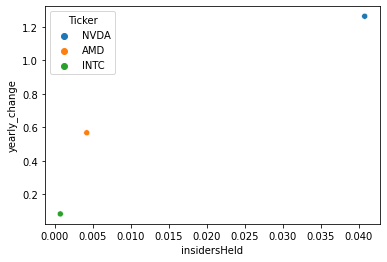

In [15]:
sns.scatterplot(data=year_change_and_insiders, x='insidersHeld', y='yearly_change', hue='Ticker')
#potentially looking at insiders holding for stocks to gauge the yearly_change

In [16]:
os.getcwd()

'c:\\Users\\huyho\\OneDrive\\Desktop\\stuff\\p-projects\\stock-forecasting'

In [17]:
#coordinates of intc, nvda, and amd HQ
latitude = [37.3860884556, 37.3691018569, 37.38242485333451]
longitude = [-121.958119501, -121.9582395, -121.97017259436115]
comp_ticker = ['INTC', 'NVDA', 'AMD']
color = ['blue', 'green', 'red'] 

t = zip(latitude, longitude, comp_ticker, color)
result_t = set(t)
result_t

{(37.3691018569, -121.9582395, 'NVDA', 'green'),
 (37.38242485333451, -121.97017259436115, 'AMD', 'red'),
 (37.3860884556, -121.958119501, 'INTC', 'blue')}

In [18]:
#given that they are all headquartered in Santa Clara, let's visualize the proximity of these companies

m = folium.Map([37.3541, -121.9552], zoom_start=12)

for lat, lon, ticker, color in result_t:
    folium.Marker([lat, lon], popup=ticker, icon=folium.Icon(color=color)).add_to(m)
m

In [19]:
nvda_table = data['NVDA']
nvda_table['Month'] = nvda_table['Open'].index.month
nvda_month_grouped = nvda_table.groupby('Month').mean()

amd_table = data['AMD']
amd_table['Month'] = amd_table['Open'].index.month
amd_month_grouped = amd_table.groupby('Month').mean()

intc_table = data['INTC']
intc_table['Month'] = intc_table['Open'].index.month
intc_month_grouped = intc_table.groupby('Month').mean()

intc_month_grouped

<ipython-input-19-3d10f01f01a9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvda_table['Month'] = nvda_table['Open'].index.month
<ipython-input-19-3d10f01f01a9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amd_table['Month'] = amd_table['Open'].index.month
<ipython-input-19-3d10f01f01a9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

,Open,High,Low,Close,Adj Close,Volume
Month,,,,,,
1,42.463148,43.017901,41.996975,42.496667,38.431226,3.470906e+07
2,43.011765,43.510654,42.551307,43.058889,39.273797,2.577163e+07
3,42.904057,43.660000,42.314514,42.972000,39.231479,3.082112e+07
4,44.498976,45.017289,43.961506,44.499157,40.624378,2.816236e+07
5,42.757798,43.185774,42.358095,42.792678,39.183769,2.311837e+07
6,43.275581,43.639070,42.816337,43.219477,39.612779,2.665397e+07
7,43.044706,43.443294,42.615588,43.063529,39.409490,2.866230e+07
8,39.818397,40.153782,39.471667,39.815833,36.071714,2.524401e+07
9,40.490210,40.894825,40.134895,40.551608,36.685905,2.592782e+07


<AxesSubplot:xlabel='Month', ylabel='Volume'>

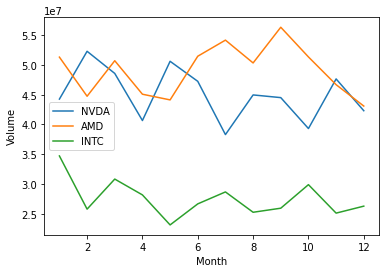

In [20]:
sns.lineplot(x=nvda_month_grouped['Volume'].index, y=nvda_month_grouped['Volume'], label='NVDA')
sns.lineplot(x=amd_month_grouped['Volume'].index, y=amd_month_grouped['Volume'], label='AMD')
sns.lineplot(x=intc_month_grouped['Volume'].index, y=intc_month_grouped['Volume'], label='INTC')
#volume seems to decrease significantly during the summer months

# Examine data before applying time-series

Common time-series data patterns:

- Level: The average value in the series
- Trend: Increases, decreases, stable
- Seasonal or Periodic: Does the pattern repeats over time
- Cyclical: Pattern that increases and decreases but usually related to non-seasonal activity, ie. business cycles
- Random or Irregular Variations: Increases and decreases that don't have any apparent patterns

<p2> The stock market prices probably falls into the Random and Irregular variations. For the model to be perfect, we must take into account financial records, social media activities, mergers and acquisitions, etc. Simply using previous prices will not yield a good model. However, we must work with the limited data that we possess.

In [21]:
import statsmodels.api as sm

In [22]:
def decomp():
    pass


# Using ARIMA

<p1> ARIMA models expect p, d, q as input parameters <p1>
1. p is the number of lag observations.
2. d is the degree of differencing.
3. q is the size/width of the moving average window. 


In [23]:
nvda = pd.DataFrame(data['NVDA']['Close'])
nvda.columns = ['Close']
nvda

,Close
Date,
2014-01-02,3.965000
2014-01-03,3.917500
2014-01-06,3.970000
2014-01-07,4.035000
2014-01-08,4.090000
...,...
2021-07-28,195.029999
2021-07-29,196.619995
2021-07-30,194.990005


In [24]:
#Before we can do ARIMA, we should look at the autocorrelation

from pandas.plotting import lag_plot

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 5)'>

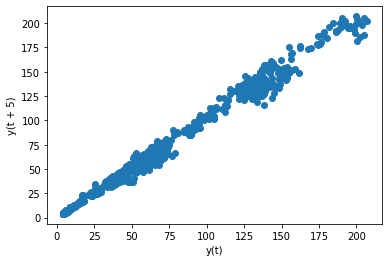

In [25]:
lag_plot(nvda['Close'], lag=5)

In [26]:
train_nvda, test_nvda = nvda[0:int(len(nvda) * 0.8)], nvda[int(len(nvda) * 0.8):]
print('training set shape', train_nvda.shape)
print('testing set shape', test_nvda.shape)

training set shape (1528, 1)
testing set shape (382, 1)


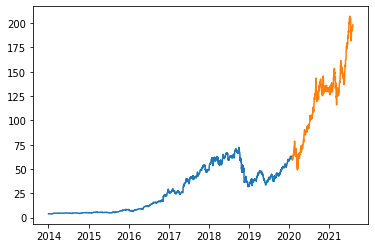

In [27]:
plt.plot(train_nvda)
plt.plot(test_nvda)

In [28]:
train_nvda, test_nvda = train_nvda.values, test_nvda.values

In [29]:
history = [x for x in train_nvda]
model_predictions = []
N_test_observations = len(test_nvda) #382

for time_point in range(N_test_observations):
    model = ARIMA(history, order=(4, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_nvda[time_point]
    history.append(true_test_value)

mse_error = mean_squared_error(test_nvda, model_predictions)
print('Testing MSE is', mse_error)

C:\Users\huyho\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Testing MSE is 12.550908427899701


In [30]:
from matplotlib.pyplot import figure

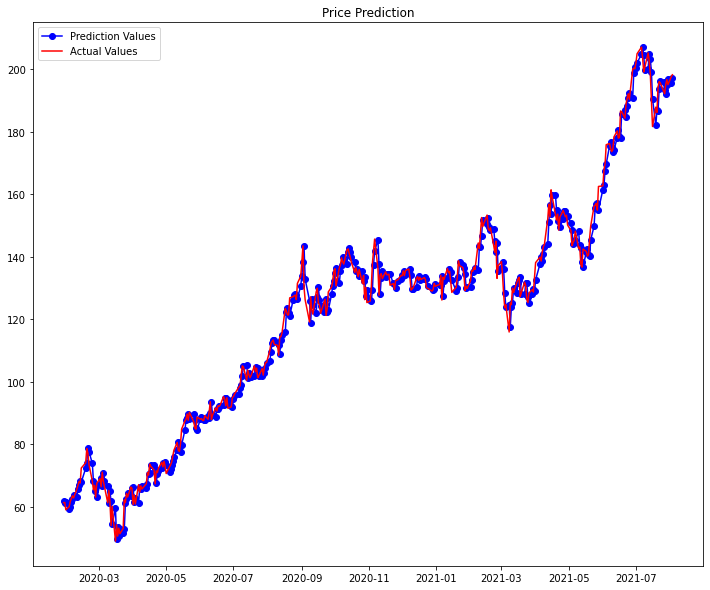

In [31]:
test_set_range = nvda[int(len(nvda) * 0.8):].index

plt.figure(figsize=(12,10))
plt.plot(test_set_range, model_predictions, color='blue', label='Prediction Values', marker='o')
plt.plot(test_set_range, test_nvda, color='red', label='Actual Values')

plt.title('Price Prediction')
plt.legend()
plt.show()

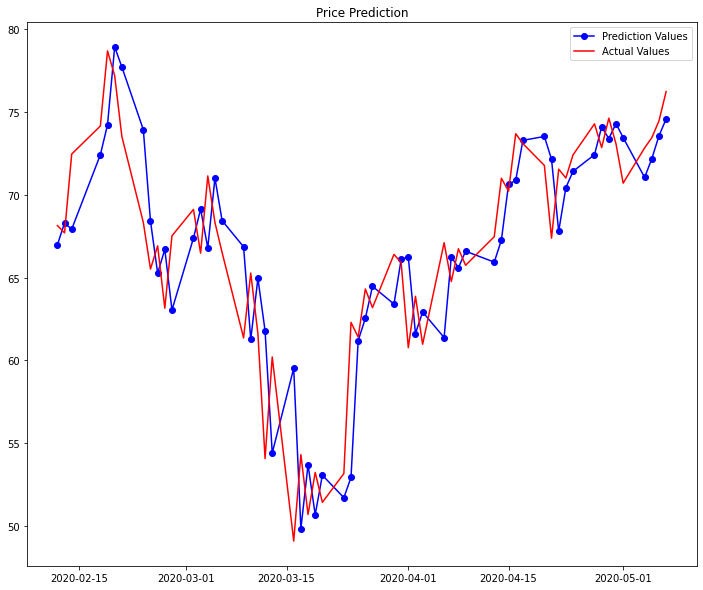

In [32]:
#looking at a smaller subset
plt.figure(figsize=(12,10))
plt.plot(test_set_range[10:70], model_predictions[10:70], color='blue', label='Prediction Values', marker='o')
plt.plot(test_set_range[10:70], test_nvda[10:70], color='red', label='Actual Values')

plt.title('Price Prediction')
plt.legend()
plt.show()

In [33]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [34]:
y_arima = train_nvda
y_arima

array([[ 3.96499991],
       [ 3.91750002],
       [ 3.97000003],
       ...,
       [62.61999893],
       [60.04999924],
       [61.99250031]])

In [35]:
armamodel = SARIMAX(y_arima, order = (1, 0,1))

In [36]:
armamodel = armamodel.fit()

C:\Users\huyho\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [37]:
y_pred_arma = armamodel.get_forecast(len(test_nvda))
y_pred_df = y_pred_arma.conf_int(alpha = 0.05)
y_pred_df

array([[60.12841585, 63.69292779],
       [59.42262843, 64.3715409 ],
       [58.87216559, 64.89483538],
       [58.40407893, 65.33575965],
       [57.98921437, 65.72346778],
       [57.61239977, 66.07313191],
       [57.26454307, 66.3938441 ],
       [56.9396853 , 66.69156331],
       [56.63366964, 66.97044638],
       [56.34345968, 67.2335297 ],
       [56.06675726, 67.48311142],
       [55.80177323, 67.72098072],
       [55.54708225, 67.94856291],
       [55.301527  , 68.16701532],
       [55.06415244, 68.377293  ],
       [54.83415953, 68.58019497],
       [54.61087172, 68.77639777],
       [54.39371019, 68.96648025],
       [54.18217509, 69.15094224],
       [53.97583129, 69.33021888],
       [53.77429716, 69.50469178],
       [53.57723584, 69.67469781],
       [53.38434818, 69.84053612],
       [53.19536709, 70.00247379],
       [53.01005292, 70.16075048],
       [52.82818966, 70.3155822 ],
       [52.64958181, 70.46716443],
       [52.47405176, 70.61567479],
       [52.30143754,

## ARIMA seems to do a pretty decent job. Of course there are instances where it might not be as reliable, for example during the market crash during the Covid-19 pandemic. However, it looks like a reliable model that is relatively simple to build.

# Using XGBOOST

In [38]:
xgboost_nvda = data['NVDA']

In [39]:
xgboost_nvda['target'] = xgboost_nvda['Close'].copy()
xgboost_nvda['target'] = xgboost_nvda['Close'].shift(-1)
xgboost_nvda.dropna(inplace=True)
xgboost_nvda

<ipython-input-39-e29f684a3415>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xgboost_nvda['target'] = xgboost_nvda['Close'].copy()
<ipython-input-39-e29f684a3415>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xgboost_nvda['target'] = xgboost_nvda['Close'].shift(-1)
<ipython-input-39-e29f684a3415>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

,Open,High,Low,Close,Adj Close,Volume,target
Date,,,,,,,
2014-01-02,3.980000,3.995000,3.930000,3.965000,3.745882,26009200,3.917500
2014-01-03,3.972500,3.980000,3.905000,3.917500,3.701007,25933200,3.970000
2014-01-06,3.957500,4.000000,3.920000,3.970000,3.750607,40949200,4.035000
2014-01-07,4.010000,4.050000,3.982500,4.035000,3.812014,33328800,4.090000
2014-01-08,4.050000,4.110000,4.035000,4.090000,3.863974,30819200,3.937500
...,...,...,...,...,...,...,...
2021-07-27,192.649994,196.220001,187.410004,192.080002,192.022629,24886300,195.029999
2021-07-28,193.190002,196.460007,189.949997,195.029999,194.971725,20219100,196.619995
2021-07-29,195.190002,198.529999,193.279999,196.619995,196.561264,19078100,194.990005


In [40]:
xgboost_nvda['target'][0] == xgboost_nvda['Close'][1]
#the target is the next date's closing price

True

In [41]:
xgboost_nvda_train, xgboost_nvda_test = xgboost_nvda[0:int(len(xgboost_nvda) * 0.8)], xgboost_nvda[int(len(xgboost_nvda) * 0.8):]
print('train length: ', len(xgboost_nvda_train))
print('test length: ', len(xgboost_nvda_test))

train length:  1527
test length:  382


In [42]:
train_X= xgboost_nvda_train.iloc[:, :-1]
train_Y= xgboost_nvda_train.iloc[:, -1]
test_X = xgboost_nvda_test.iloc[:, :-1]
test_Y = xgboost_nvda_test.iloc[:, -1]

In [43]:
train_X

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,3.980000,3.995000,3.930000,3.965000,3.745882,26009200
2014-01-03,3.972500,3.980000,3.905000,3.917500,3.701007,25933200
2014-01-06,3.957500,4.000000,3.920000,3.970000,3.750607,40949200
2014-01-07,4.010000,4.050000,3.982500,4.035000,3.812014,33328800
2014-01-08,4.050000,4.110000,4.035000,4.090000,3.863974,30819200
...,...,...,...,...,...,...
2020-01-21,61.952499,62.322498,61.642502,61.985001,61.828888,21791600
2020-01-22,62.439999,63.397499,62.250000,62.527500,62.370022,23924000
2020-01-23,62.930000,63.299999,62.037498,63.215000,63.055790,24451600


In [44]:
modelXGB = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
modelXGB.fit(train_X, train_Y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

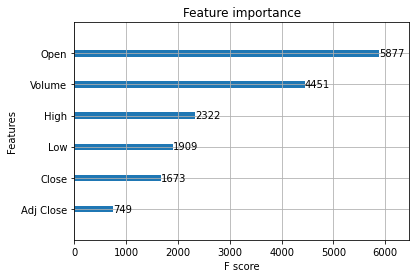

In [45]:
importance = plot_importance(modelXGB)

# Using Keras

In [46]:
nvda_train = nvda[:int(len(nvda) * 0.7)]
nvda_test = nvda[int(len(nvda) * 0.7):]
print('nvda train:' , len(nvda_train))
print('nvda test:' , len(nvda_test))

nvda train: 1337
nvda test: 573


In [47]:
display(nvda_train, nvda_test)

,Close
Date,
2014-01-02,3.965000
2014-01-03,3.917500
2014-01-06,3.970000
2014-01-07,4.035000
2014-01-08,4.090000
...,...
2019-04-18,46.575001
2019-04-22,47.117500
2019-04-23,47.667500


,Close
Date,
2019-04-26,44.522499
2019-04-29,44.832500
2019-04-30,45.250000
2019-05-01,45.117500
2019-05-02,45.797501
...,...
2021-07-28,195.029999
2021-07-29,196.619995
2021-07-30,194.990005


In [78]:
scaler = MinMaxScaler()
scaler.fit(nvda_train)

MinMaxScaler()

In [79]:
scaled_train = scaler.transform(nvda_train)
scaled_test = scaler.transform(nvda_test)

In [80]:
n_input = 300 #window size of 300
n_feature = 1 #univariate


#creating the generator for training and testing
train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
test_generator = TimeseriesGenerator(scaled_test, scaled_test, length=n_input, batch_size=1)

In [81]:
#MODEL

model = Sequential()

model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same', input_shape=(n_input, n_feature))) #(200, 1)
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=n_feature)) #1
model.compile(optimizer='adam', loss='mse')

#stochastic gradient descent sgd, mse is best for outlier detection

In [82]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 300, 512)          2048      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 150, 512)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 150, 256)          393472    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 75, 256)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 75, 128)           98432     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 37, 128)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 37, 64)           

In [83]:
model.fit(train_generator, epochs=5, batch_size=50, verbose=2)

Epoch 1/5
1037/1037 - 7s - loss: 0.0176
Epoch 2/5
1037/1037 - 6s - loss: 0.0015
Epoch 3/5
1037/1037 - 6s - loss: 0.0013
Epoch 4/5
1037/1037 - 6s - loss: 9.3058e-04
Epoch 5/5
1037/1037 - 6s - loss: 0.0012


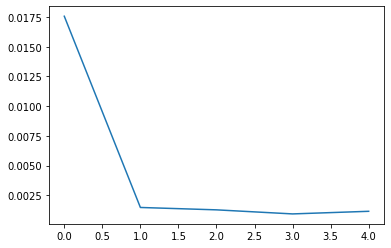

In [84]:
model_loss= model.history.history['loss']
plt.plot(range(len(model_loss)), model_loss)

In [85]:
test_predictions = []
train_predictions = []

#how far into the future will I forecast?
#loop through test window
for x,_ in test_generator:
    
    # One timestep ahead of historical 300 points
    current_pred = model.predict(x)
    
    #store that prediction
    test_predictions.append(current_pred[0])


for x,_ in train_generator:
    
    # One timestep ahead of historical 300 points
    current_pred_train = model.predict(x)
    
    #store that prediction
    train_predictions.append(current_pred_train[0])


#reverse the scaled into normal total_mbps
train_predictions = scaler.inverse_transform(train_predictions)
true_predictions = scaler.inverse_transform(test_predictions)

In [86]:
test_result = nvda_test[300:]
test_result['predictions'] = true_predictions
test_result

<ipython-input-86-ce4dfb7dfde5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_result['predictions'] = true_predictions


,Close,predictions
Date,,
2020-07-06,98.392502,97.436215
2020-07-07,98.717499,99.011699
2020-07-08,102.160004,100.006567
2020-07-09,105.089996,102.296047
2020-07-10,104.792503,105.648825
...,...,...
2021-07-28,195.029999,190.244574
2021-07-29,196.619995,192.602753
2021-07-30,194.990005,194.699887


In [87]:
import seaborn as sns 

<AxesSubplot:xlabel='Date', ylabel='Close'>

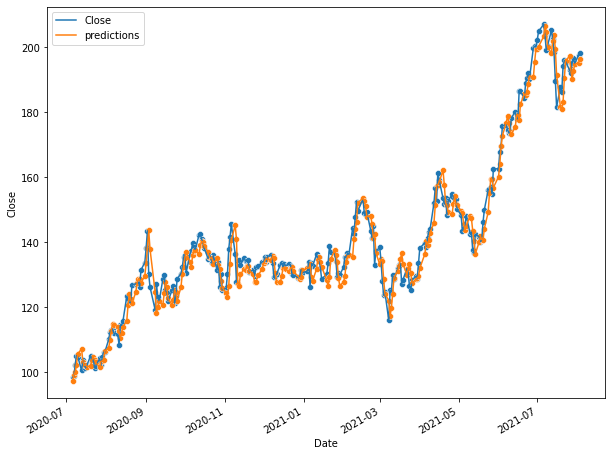

In [88]:
test_result[['Close', 'predictions']].plot(figsize=(10,8))
sns.scatterplot(x=test_result.index, y=test_result.Close)
sns.scatterplot(x=test_result.index, y=test_result.predictions)

<AxesSubplot:xlabel='Date'>

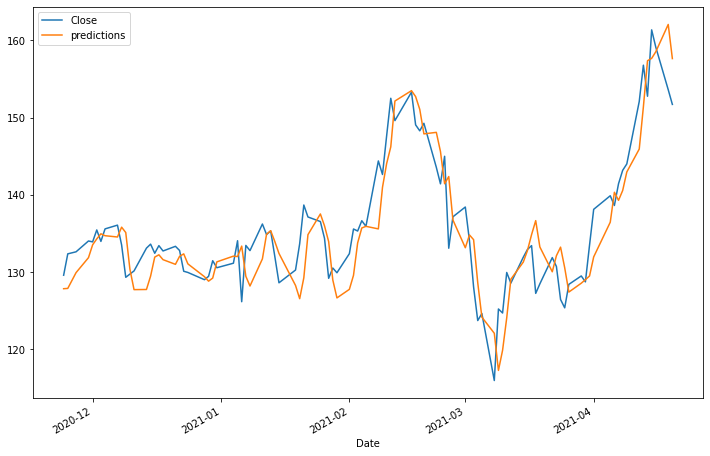

In [89]:
test_result[['Close', 'predictions']][100:200].plot(figsize=(12,8))

In [90]:
#train results
train_result = nvda_train[300:]
train_result['predictions'] = train_predictions
train_result

<ipython-input-90-a8f80c9b14dd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_result['predictions'] = train_predictions


,Close,predictions
Date,,
2015-03-13,5.675000,5.904864
2015-03-16,5.742500,5.913760
2015-03-17,5.812500,5.918194
2015-03-18,5.717500,5.930184
2015-03-19,5.805000,5.935762
...,...,...
2019-04-18,46.575001,48.047835
2019-04-22,47.117500,47.980557
2019-04-23,47.667500,48.183429


<AxesSubplot:xlabel='Date'>

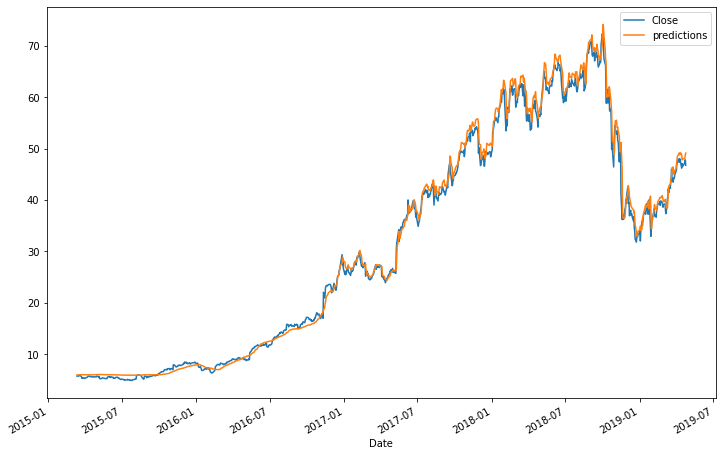

In [91]:
train_result.plot(figsize=(12,8))

<AxesSubplot:xlabel='Date'>

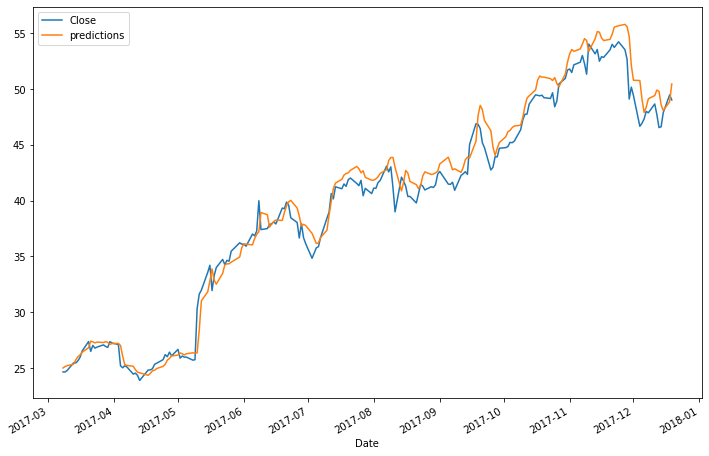

In [92]:
train_result[500:700].plot(figsize=(12,8))

In [93]:
test_result

,Close,predictions
Date,,
2020-07-06,98.392502,97.436215
2020-07-07,98.717499,99.011699
2020-07-08,102.160004,100.006567
2020-07-09,105.089996,102.296047
2020-07-10,104.792503,105.648825
...,...,...
2021-07-28,195.029999,190.244574
2021-07-29,196.619995,192.602753
2021-07-30,194.990005,194.699887


In [94]:
mse = mean_squared_error(y_true=test_result['Close'], y_pred=test_result['predictions'])
mse
#mse of ~90 is decent.

17.92800210559881

This machine learning techniques using Keras can be quite inconsistent. Sometimes when I run it, the results would differ from another. Nevertheless, it is quite good and can be trained relatively quickly. 

#test